#### 1) Zero-Coupon Yields (Bootstrapping)


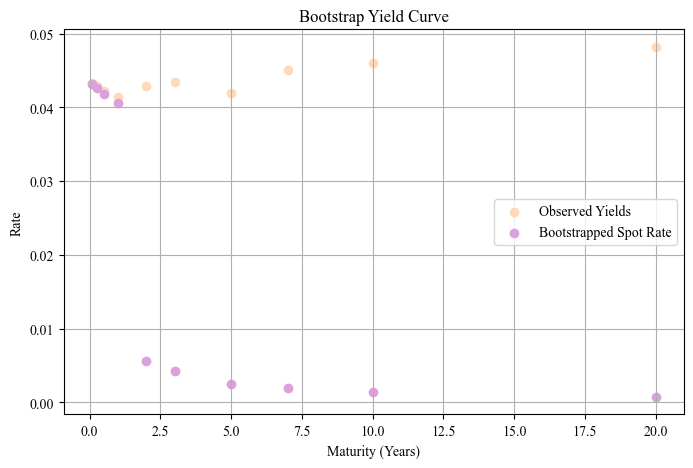

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, Eq, solve, log

# Data
data = { 'Year': [1/12, 3/12, 6/12, 1, 2, 3, 5, 7 ,10, 20],
         'Yield': [0.0433, 0.0429, 0.0422, 0.0414, 0.0429, 0.0434, 0.042, 0.0451, 0.046, 0.0482]}
df = pd.DataFrame(data)

spot = []

# Get spot rates for T ≤ 1 year
for i in range(0, 4):
    T = df['Year'][i]
    P = 1 - df['Yield'][i] * T
    if P <= 0:
        raise ValueError(f"Invalid discount factor P={P} at T={T}")  # Debugging check
    zcy = -1/T * np.log(P)
    spot.append(zcy)

# Get spot rates for T > 1 year
x = symbols('x')
for i in range(4, 10):
    T = df['Year'][i]
    mkt_rate = df['Yield'][i]
    
    # Compute sum of previous spot rates correctly
    prev_spots_sum = sum(spot[2:i-1]) if i > 4 else 0  
    
    # Bootstrap equation
    eq = Eq(0.5 * mkt_rate * (prev_spots_sum + (spot[i-1] + x)/2 + x) + x - 1, 0)
    solution = solve(eq, x)[0]
    
    # Convert to numeric and apply log correctly
    solution = float(solution)
    if solution <= 0:
        raise ValueError(f"Invalid solution={solution} at T={T}")  # Debugging check
    spot_rate = -1/T * log(solution)
    spot.append(float(spot_rate))  # Ensure it's a numeric value

df['Spot'] = spot  # Update DataFrame

# Plot 
plt.figure(figsize=(8,5))
plt.rcParams['font.family'] = 'times new roman'
plt.scatter(df['Year'], df['Yield'], marker='o', label='Observed Yields', color='peachpuff')  # Fixed marker
plt.scatter(df['Year'], df['Spot'], marker='o', label='Bootstrapped Rate', color='plum')  # Fixed line plot
plt.xlabel('Maturity (Years)')
plt.ylabel('Rate')
plt.title('Bootstrap Yield Curve')
plt.legend()
plt.grid(True)
plt.show()


#### 2) Zero-Coupon Yields (Nelson-Siegel-Svensson) 

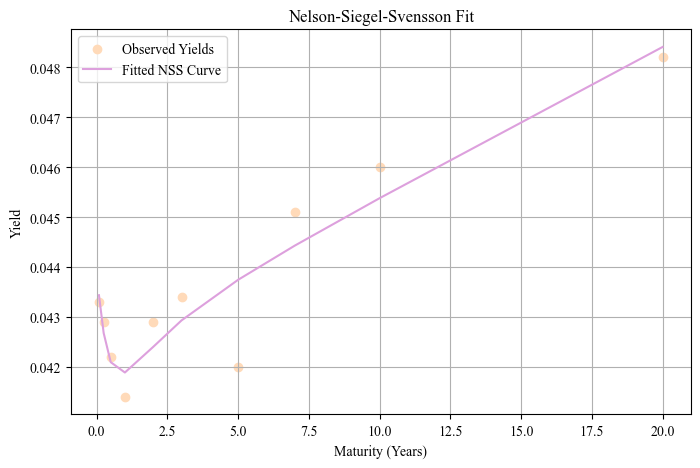

Objective Function (SSE) = 0.0000047095
                  0         1         2         3         4           5
Parameter        β0        β1        β2        β3        τ1          τ2
Value      0.042665  0.001319 -0.005431 -0.543325  0.440554 -944.765301


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Nelson-Siegel-Svensson model
def nss_model(t, beta_0, beta_1, beta_2, beta_3, tau_1, tau_2):
    t = np.maximum(t, 1e-6)  # Avoid division by zero
    term1 = (1 - np.exp(-t/tau_1)) / (t/tau_1)
    term2 = term1 - np.exp(-t/tau_1)
    term3 = (1 - np.exp(-t/tau_2)) / (t/tau_2) - np.exp(-t/tau_2)
    return beta_0 + beta_1 * term1 + beta_2 * term2 + beta_3 * term3

# Initial guess
initial_guess = [0.04, -0.02, 0.02, -0.01, 1.0, 5.0]

# Fit model to data (convert pandas Series to NumPy arrays)
params, covariance = curve_fit(nss_model, df['Year'].values, df['Yield'].values, p0=initial_guess)

# Extract fitted parameters
beta_0, beta_1, beta_2, beta_3, tau_1, tau_2 = params

# Compute fitted yields using estimated parameters
fitted_yields = nss_model(df['Year'].values, *params)

# Objective function (sum of squared errors)
sse = np.sum((df['Yield'].values - fitted_yields) ** 2)

# Plot 
plt.figure(figsize=(8,5))
plt.rcParams['font.family'] = 'times new roman'

# Scatter plot for observed yields
plt.scatter(df['Year'], df['Yield'], marker='o', label='Observed Yields', color='peachpuff')

# Line plot for the fitted NSS curve
plt.plot(df['Year'], fitted_yields, '-', label='Fitted NSS Curve', color='plum')

plt.xlabel('Maturity (Years)')
plt.ylabel('Yield')
plt.title('Nelson-Siegel-Svensson Fit')
plt.legend()
plt.grid(True)
plt.show()

# Output results
print(f"Objective Function (SSE) = {sse:.10f}")

# Create DataFrame for fitted parameters
fitted_parameters = pd.DataFrame({'Parameter': ['β0', 'β1', 'β2', 'β3', 'τ1', 'τ2'],
                                  'Value': [beta_0, beta_1, beta_2, beta_3, tau_1, tau_2]})

# Transpose DataFrame for display
print(fitted_parameters.T)


#### 3) Cap Prices (Brigo-Mercurio)

In [13]:
from scipy.optimize import minimize
from scipy.stats import norm

# implied volatilities on cap market
data_caps = { 'Year': [1,3,5,7,10,20],
            '0.95Kf': [0.157, 0.176,0.175,0.168, 0.155, 0.142],
            'Kf':[0.152, 0.164,0.161,0.156, 0.148, 0.126],
            '1.05Kf':[0.146, 0.157, 0.158, 0.152, 0.140, 0.121]}
df_caps = pd.DataFrame(data_caps)
df_caps


In [26]:
data_caps = {
    'Year': [1, 3, 5, 7, 10, 20],
    '0.95Kf': [0.157, 0.176, 0.175, 0.168, 0.155, 0.142],
    'Kf': [0.152, 0.164, 0.161, 0.156, 0.148, 0.126],
    '1.05Kf': [0.146, 0.157, 0.158, 0.152, 0.140, 0.121]
}

df_caps = pd.DataFrame(data_caps)
df_caps
print(df_caps.dtypes)


Year        int64
0.95Kf    float64
Kf        float64
1.05Kf    float64
dtype: object


Optimal parameters:
kappa (mean reversion): 4.149692240771351
sigma (volatility): 0.42844899420679616
theta (long-term mean): 0.05
Minimized objective function value: 0.16867774319554674


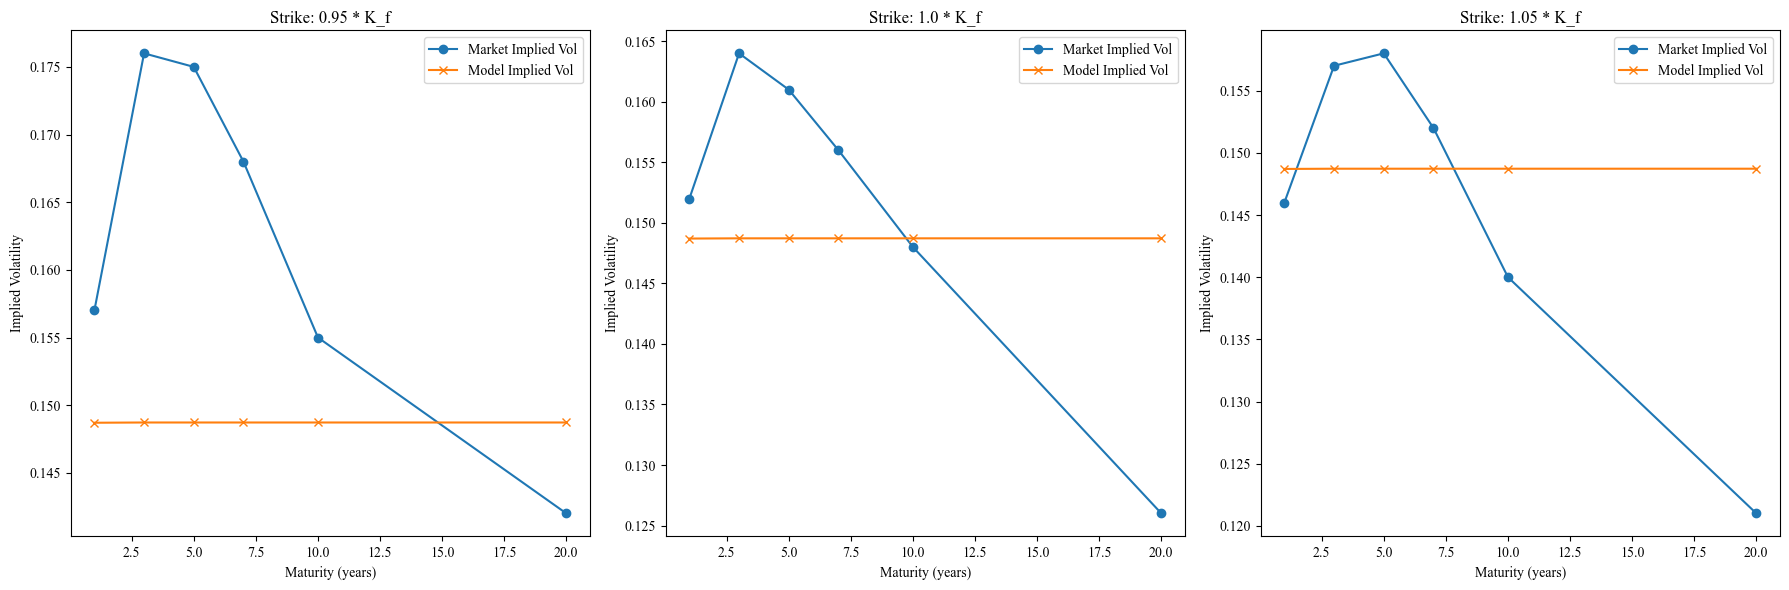

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm

# Black's formula for caplet pricing
def black76_price(F, K, sigma, T, r=0.0):
    d1 = (np.log(F / K) + (0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    price = np.exp(-r * T) * (F * norm.cdf(d1) - K * norm.cdf(d2))
    return price

# Brigo-Mercurio model cap price function (non-stochastic volatility)
def cap_bm(F, K, T, kappa, sigma, theta):
    # Closed-form solution for the caplet price under the Brigo-Mercurio model
    # This is a placeholder; replace with the actual closed-form solution or numerical method
    # For simplicity, we assume a closed-form solution exists
    # Here, we use Black's formula with an effective volatility as an approximation
    effective_vol = sigma * np.sqrt((1 - np.exp(-2 * kappa * T)) / (2 * kappa))
    return black76_price(F, K, effective_vol, T)

# Objective function to minimize
def objective_function(params, strikes, maturities, K_f, implied_vols):
    kappa, sigma, theta = params  # Unpack the parameters
    error = 0.0
    for j in range(len(strikes)):
        for k in range(len(maturities)):
            K = strikes[j] * K_f[k]  # Strike is a multiple of K_f
            T = maturities[k]
            sigma_mkt = implied_vols[k, j]
            cap_mkt = black76_price(K_f[k], K, sigma_mkt, T)
            cap_model = cap_bm(K_f[k], K, T, kappa, sigma, theta)
            error += ((cap_model - cap_mkt) / cap_mkt) ** 2
    return error

# Given data
t = 0.003  # Fraction of the year elapsed
strikes = np.array([0.95, 1.00, 1.05])  # Strikes as multiples of K_f
maturities = np.array([1, 3, 5, 7, 10, 20])  # Maturities in years
K_f = np.array([0.03, 0.035, 0.04, 0.045, 0.05, 0.055])  # Forward swap rates (replace with actual values)
implied_vols = np.array([
    [0.157, 0.152, 0.146],
    [0.176, 0.164, 0.157],
    [0.175, 0.161, 0.158],
    [0.168, 0.156, 0.152],
    [0.155, 0.148, 0.140],
    [0.142, 0.126, 0.121]
])

# Initial guess for the parameters
params0 = np.array([1.0, 0.1, 0.05])  # Example: [kappa, sigma, theta]

# Minimize the objective function
result = minimize(objective_function, params0, args=(strikes, maturities, K_f, implied_vols))

# Optimal parameters
kappa_opt, sigma_opt, theta_opt = result.x
print("Optimal parameters:")
print("kappa (mean reversion):", kappa_opt)
print("sigma (volatility):", sigma_opt)
print("theta (long-term mean):", theta_opt)
print("Minimized objective function value:", result.fun)

# Plotting the results side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns of subplots

for j in range(len(strikes)):
    ax = axes[j]
    ax.plot(maturities, implied_vols[:, j], 'o-', label="Market Implied Vol")
    model_vols = [sigma_opt * np.sqrt((1 - np.exp(-2 * kappa_opt * T)) / (2 * kappa_opt)) for T in maturities]
    ax.plot(maturities, model_vols, 'x-', label="Model Implied Vol")
    ax.set_title(f"Strike: {strikes[j]} * K_f")
    ax.set_xlabel("Maturity (years)")
    ax.set_ylabel("Implied Volatility")
    ax.legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()